In [1]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparrowpy as sp
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
# %matplotlib ipympl

Define the parameters and geometry for the simulation.

In [2]:
# Define parameters
X = 5
Y = 6
Z = 4
patch_size = 0.5
ir_length_s = 2
sampling_rate = 1000
max_order_k = 5
speed_of_sound = 346.18
absorption = 0.1

# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source_pos = [2, 2, 2]
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = [2, 3, 2]

Calculate old slow approach for comparison.

In [3]:
start = datetime.now()
# init object
radi = sp.radiosity.Radiosity(
    walls, patch_size, max_order_k, ir_length_s,
    speed_of_sound=speed_of_sound, sampling_rate=sampling_rate)

# run simulation
radi.run(source)

# gather energy at receiver
receiver = sp.geometry.Receiver(receiver_pos, [0, 1, 0], [0, 0, 1])
ir_slow = radi.energy_at_receiver(receiver, ignore_direct=True)
reverberation_slow = pf.Signal(ir_slow, sampling_rate=sampling_rate)

# stop timer
delta = (datetime.now() - start)
print(f"Time elapsed: {delta}")
slow_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

/Users/anne/git/_pyfar/sparrowpy/sparrowpy/radiosity.py:60: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums
100%|██████████| 5/5 [00:21<00:00,  4.30s/it]

Time elapsed: 0:00:27.496552


Calculate new fast approach

In [3]:
start = datetime.now()

# create object
radiosity_fast = sp.DRadiosityFast.from_polygon(walls, patch_size)

# create directional scattering data (totally diffuse)
frequencies = np.array([500])

# set directional scattering data
coords = pf.Coordinates(0, 0, 1, weights=1)
s = pf.FrequencyData([1], frequencies)
brdf = sp.brdf.create_from_scattering(coords, coords, s)
radiosity_fast.set_wall_scattering(
    np.arange(len(walls)),
    brdf,
    sources=coords,
    receivers=coords)

# set air absorption
radiosity_fast.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(frequencies),
        frequencies))

# set absorption coefficient
radiosity_fast.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(frequencies)+absorption,
        frequencies))

# calculate from factors including directivity and absorption
radiosity_fast.bake_geometry(algorithm='order')

# initialize source energy at each patch
radiosity_fast.init_source_energy(source_pos, algorithm='order')

# gather energy at receiver
radiosity_fast.calculate_energy_exchange(
    speed_of_sound=speed_of_sound,
    histogram_time_resolution=1/sampling_rate,
    histogram_length=ir_length_s,
    algorithm='order', max_depth=max_order_k)

ir_fast = radiosity_fast.collect_receiver_energy(
    receiver_pos,
    )

reverberation_fast = pf.Signal(
    np.sum(ir_fast[0, :, 0], axis=0),
    sampling_rate=sampling_rate)


# stop timer
delta = (datetime.now() - start)
print(f"Time elapsed: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_70277/1436651392.py:13: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity_fast.set_wall_scattering(
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/anne/git/_pyfar/sparrowpy/sparrowpy/radiosity_fast/form_factor.py:198: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  form_factors[i,j] = calc_form_factor(


Time elapsed: 0:05:12.087398


In [5]:
ir_fast = radiosity_fast.collect_receiver_energy(
    receiver_pos,
    )

reverberation_fast = pf.Signal(
    ir_fast,
    sampling_rate=sampling_rate)
reverberation_fast.freq

array([[[0.08532862+0.00000000e+00j, 0.08392351-1.47318817e-02j,
         0.0797693 -2.88961377e-02j, ..., 0.00029082+5.24514682e-05j,
         0.00029435+2.63332264e-05j, 0.00029553+0.00000000e+00j]]])

Calculate the analytical reference after Kuttruff.

In [6]:

S = (2*X*Y) + (2*X*Z) + (2*Y*Z)
A = S*absorption
alpha_dash = A/S
r_h = 1/4*np.sqrt(A/np.pi)
print(f'reverberation distance is {r_h}m')
V = X*Y*Z
RT = 24*np.log(10)/(speed_of_sound)*V/(-S*np.log(1-alpha_dash))
print(f'reverberation time is {RT}s')
E_reverb_analytical = 4/A
t = reverberation_fast.times
# Kuttruff Eq 4.7
w_0 = E_reverb_analytical/ V
t_0 = 0.03
# Kuttruff Eq 4.10
reverberation_analytic = w_0 * np.exp(+(
    speed_of_sound*S*np.log(1-alpha_dash)/(4*V))*(t-t_0))
reverberation_analytic = pf.Signal(
    reverberation_analytic, sampling_rate=sampling_rate)

reverberation distance is 0.5426201661567753m
reverberation time is 1.228475783983933s


Plot comparison

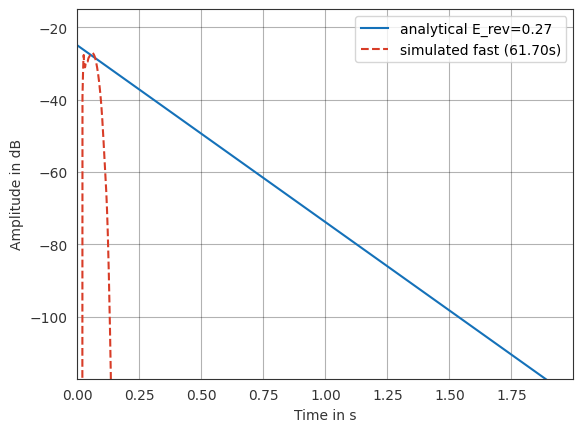

In [7]:
plt.figure()
pf.plot.time(
    reverberation_analytic, dB=True, log_prefix=10,
    label=f'analytical E_rev={E_reverb_analytical:0.2f}')
# pf.plot.time(
#     reverberation_slow, dB=True, log_prefix=10,
#     label=f'simulated slow ({slow_time_s:0.2f}s)',
#     linestyle='-')
pf.plot.time(
    reverberation_fast, dB=True, log_prefix=10,
    label=f'simulated fast ({fast_time_s:0.2f}s)',
    linestyle='--')

plt.legend()
plt.show()

In [8]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.10.16
IPython version      : 8.31.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.10.0
pyfar     : 0.7.1
sparrowpy : 0.1.0
numpy     : 1.26.4

